In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [48]:
pp = pprint.PrettyPrinter(indent = 3)

In [49]:
df = pd.read_csv("supernova_dataset.csv")
print(df.shape)
df.head()

(9564, 26)


,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,2.26,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,2.83,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,14.60,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,33.46,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,2.75,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


# Counting NaN Values

In [50]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}

In [51]:
pp.pprint(nan_columns)

{  'feh_err1': 109,
   'feh_err2': 109,
   'koi_depth': 363,
   'koi_impact': 363,
   'koi_model_snr': 363,
   'koi_num_transits': 1142,
   'koi_prad': 363,
   'koi_ror': 363,
   'logg_err1': 109,
   'logg_err2': 109,
   'mass_err1': 109,
   'mass_err2': 109,
   'radius_err1': 109,
   'radius_err2': 109,
   'st_dens': 109,
   'st_mass': 109,
   'teff_err1': 109,
   'teff_err2': 109}


## Preliminary Cleaning

### Removing Mostly NaN Rows

A threshold is set such that rows in which atleast **20%** of the fields are NaN are dropped.

In [52]:
df = df[~(df.isnull().sum(axis=1) > int((0.2)*df.shape[1]))]

In [53]:
print(df.shape)

(9202, 26)


The number of rows has decreased from 9564 to 9202

# Replacing NaN Values

There are two broad types of NaN values present.
* NaN in Error Values - These include the positive and negative error in estimating attributes
* NaN in Measurable Attributes - These include missing values in measuring attributes

## Replacing NaN in Error Values

### Finding Error Attributes with NaN

In [54]:
missing_error_attribute_names = [attr for attr in df.columns if "err" in attr]
pp.pprint(missing_error_attribute_names)

[  'teff_err1',
   'teff_err2',
   'logg_err1',
   'logg_err2',
   'feh_err1',
   'feh_err2',
   'mass_err1',
   'mass_err2',
   'radius_err1',
   'radius_err2']


the error columns are **effective temperature, surface gravity, metallicity, mass and radius** (of the stars)

Since these are positive and negative error measures for the corresponding attributes, we can do either of the following
* Replace with the mean or median of the attribute errors
* Drop the rows
* Replace with a default value = 0
* Take a look at the percentage error between the column and its associated error

We cannot use regression based techniques to estimate the error since
* A greater set of values does not mean a greater error
* The errors consist of errors while estimating a value and do not depend on any of the attributes

### Finding Distributions of Error Attributes

Let us first extract a slice of the dataset that contains the error attributes

In [55]:
missing_error_values_df = df[missing_error_attribute_names].copy()
print(missing_error_values_df.shape)
missing_error_values_df.head()

(9202, 10)


,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


We can now find the mean and median of the remaining columns

In [56]:
error_attribute_means = np.nanmean(missing_error_values_df.values, axis=0)
error_attribute_means

array([ 1.43448000e+02, -1.57469898e+02,  1.12402521e-01, -1.73180178e-01,
        2.16326559e-01, -2.41341230e-01,  1.35677217e-01, -1.38586829e-01,
        4.27612747e-01, -3.54866279e-01])

In [57]:
error_attribute_medians = np.nanmedian(missing_error_values_df.values, axis=0)
error_attribute_medians

array([ 1.53e+02, -1.49e+02,  7.40e-02, -1.93e-01,  2.20e-01, -2.60e-01,
        1.15e-01, -9.79e-02,  3.56e-01, -1.14e-01])

There seems to be some difference in the median and mean values, suggesting skewed data for attributes.<br>
We might need to plot each and decide when we can take the mean or the median.

for all the columns
```
for col in missing_error_attribute_names:
    median_val = np.nanmedian(df[col].values)
    df[col].fillna(median_val, inplace=True)
```



## Replacing NaN in Effective Temperature

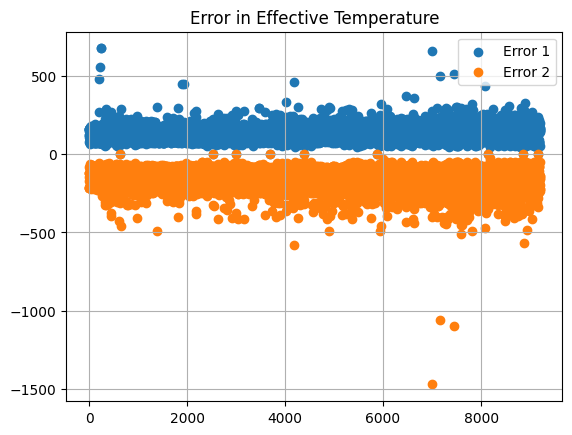

In [58]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err2"].values, label = "Error 2")
plt.title("Error in Effective Temperature")
plt.grid()
plt.legend()

### Viewing Frequency Distribution

#### Positive Error

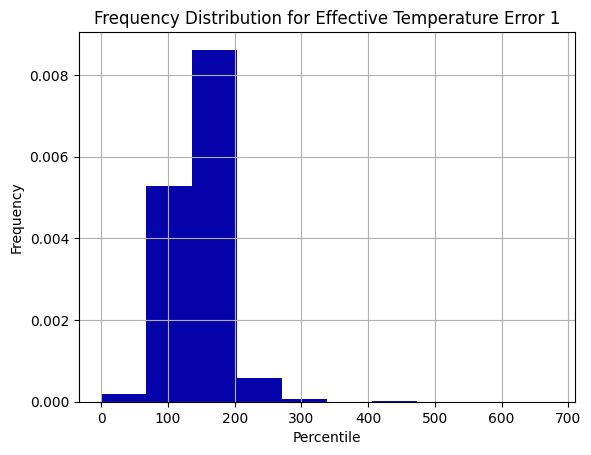

In [59]:
plt.hist(missing_error_values_df["teff_err1"].values, color = "#0504aa", density=True)
plt.title("Frequency Distribution for Effective Temperature Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

In [60]:
df["teff_err1"] = df["teff_err1"].fillna(
    np.nanpercentile(missing_error_values_df["teff_err1"], 50)
)

#### Negative Error

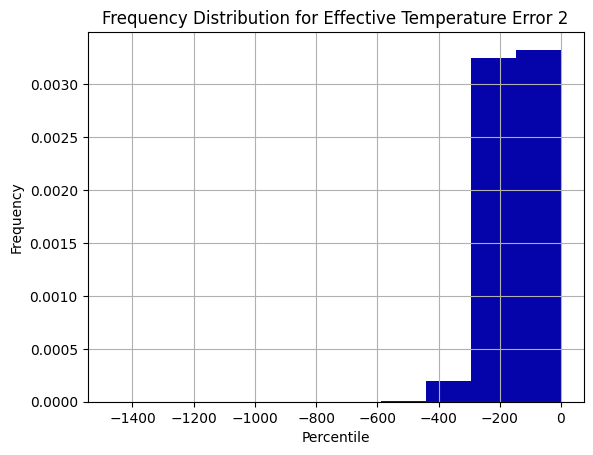

In [61]:
plt.hist(missing_error_values_df["teff_err2"].values, color="#0504aa", density = True)
plt.title("Frequency Distribution for Effective Temperature Error 2")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

In [62]:
df["teff_err2"].fillna(np.nanpercentile(missing_error_values_df["teff_err2"].values, 50), inplace = True)

/tmp/ipython-input-157265513.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["teff_err2"].fillna(np.nanpercentile(missing_error_values_df["teff_err2"].values, 50), inplace = True)


## Replacing NaN in Surface Gravity

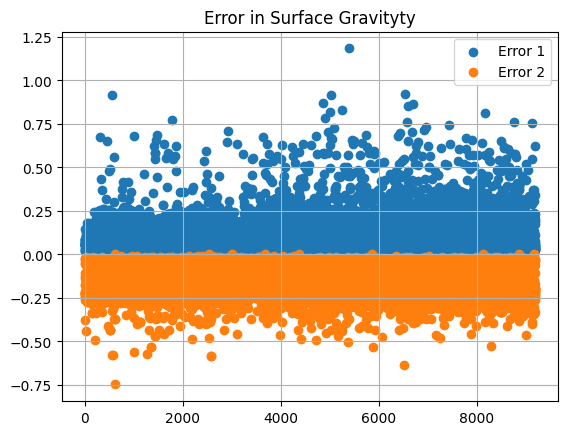

In [63]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()
plt.grid()

### Viewing Frequency Distribution

#### Positive Error

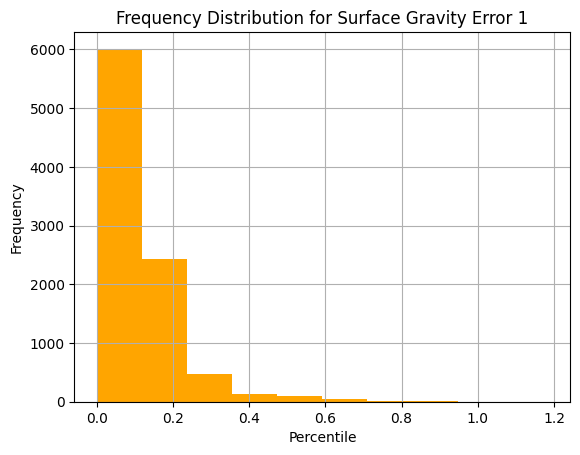

In [64]:
plt.hist(missing_error_values_df["logg_err1"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

In [65]:
df["logg_err1"].fillna(np.nanpercentile(missing_error_values_df["logg_err1"].values, 50), inplace = True)

/tmp/ipython-input-1029745993.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["logg_err1"].fillna(np.nanpercentile(missing_error_values_df["logg_err1"].values, 50), inplace = True)


#### Negative Error

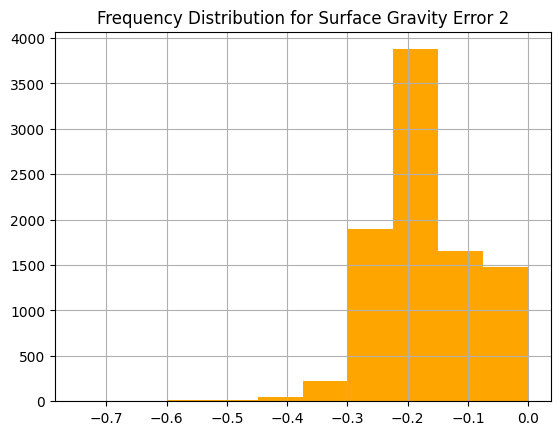

In [66]:
plt.hist(missing_error_values_df["logg_err2"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 2")
plt.grid()

In [67]:
df["logg_err2"].fillna(np.nanpercentile(missing_error_values_df["logg_err2"].values, 50), inplace = True)

/tmp/ipython-input-3274536013.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["logg_err2"].fillna(np.nanpercentile(missing_error_values_df["logg_err2"].values, 50), inplace = True)


## Replacing NaN in Impact Parameter

### Viewing Frequency Distribution

In [68]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err2"].values, label = "Error 2")
plt.title("Error in Impact Parameter")
plt.legend()
plt.grid()

KeyError: 'koi_impact_err1'

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_impact_err1"].values, color="darkred")
plt.title("Frequency Distribution for Impact Parameter Error 1")
plt.grid()

In [ ]:
df["koi_impact_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_impact_err2"].values, color="darkred")
plt.title("Frequency Distribution for Impact Parameter Error 2")
plt.grid()

In [ ]:
df["koi_impact_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 50), inplace = True)

## Replacing NaN in Transit Duration

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err2"].values, label = "Error 2")
plt.title("Error in Transit Duration")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_duration_err1"].values, color="lightblue")
plt.title("Frequency Distribution for Transit Duration Error 1")
plt.grid()

In [ ]:
df["koi_duration_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_duration_err2"].values, color="lightblue")
plt.title("Frequency Distribution for Transit Duration Error 2")
plt.grid()

In [ ]:
df["koi_duration_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 50), inplace = True)

## Replacing NaN in Transit Depth

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err2"].values, label = "Error 2")
plt.title("Error in Transit Depth")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_depth_err1"].values, color="darkviolet")
plt.title("Frequency Distribution for Transit Depth Error 1")
plt.grid()

In [ ]:
df["koi_depth_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_depth_err2"].values, color="darkviolet")
plt.title("Frequency Distribution for Transit Depth Error 2")
plt.grid()

In [ ]:
df["koi_depth_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 50), inplace = True)

## Replacing NaN in Planet Radius

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err2"].values, label = "Error 2")
plt.title("Error in Planet Radius")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_prad_err1"].values, color="orange")
plt.title("Frequency Distribution for Planet Radius Error 1")
plt.grid()

In [ ]:
df["koi_prad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_prad_err2"].values, color="orange")
plt.title("Frequency Distribution for Planet Radius Error 2")
plt.grid()

In [ ]:
df["koi_prad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 50), inplace = True)

## Replacing NaN in  Insolation Flux

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err2"].values, label = "Error 2")
plt.title("Error in Insolation Flux")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_insol_err1"].values, color="maroon")
plt.title("Frequency Distribution for Insolation Flux Error 1")
plt.grid()

In [ ]:
df["koi_insol_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_insol_err2"].values, color="maroon")
plt.title("Frequency Distribution for Insolation Flux Error 2")
plt.grid()

In [ ]:
df["koi_insol_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 50), inplace = True)

## Replacing NaN in Stellar Effective Temperature

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err2"].values, label = "Error 2")
plt.title("Error in Stellar Effective Temperature")
plt.legend()
plt.grid()

### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_steff_err1"].values, color="#0504aa")
plt.title("Frequency Distribution for Stellar Effective Temperature Error 1")
plt.grid()

In [ ]:
df["koi_steff_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 50), inplace = True)

### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_steff_err2"].values, color="#0504aa")
plt.title("Frequency Stellar Effective Temperature Error 2")
plt.grid()

In [ ]:
df["koi_steff_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 50), inplace = True)

## Replacing NaN in Surface Gravity

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_slogg_err1"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 1")
plt.grid()

In [ ]:
df["koi_slogg_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_slogg_err2"].values, color = "orange")
plt.title("Frequency Distribution for Surface Gravity Error 2")
plt.grid()

In [ ]:
df["koi_slogg_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 50), inplace = True)

## Replacing NaN in Stellar Radius

### Viewing Frequency Distribution

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err2"].values, label = "Error 2")
plt.title("Error in Stellar Radius")
plt.legend()
plt.grid()

#### Positive Error

In [ ]:
plt.hist(missing_error_values_df["koi_srad_err1"].values, color="darkred")
plt.title("Frequency Distribution for Stellar Radius Error 1")
plt.grid()

In [ ]:
df["koi_srad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 50), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_srad_err2"].values, color="darkred")
plt.title("Frequency Distribution for Stellar Radius Error 2")
plt.grid()

In [ ]:
df["koi_srad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 50), inplace = True)

## Finding Errors in Non-Error Attributes

In [ ]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

## Replacing NaN in Transit Depth

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_depth"].values, label = "Transit Depth", color ="orange")
plt.title("Transit Depth")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_depth"].values, bins=5, color="lightblue")
plt.title("Frequency Distribution for Transit Depth")
plt.grid()

In [ ]:
df["koi_depth"].fillna(np.nanpercentile(df["koi_depth"].values, 50), inplace = True)

## Replacing NaN in Impact Parameter

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_impact"].values, label = "Impact Parameter", color="blue")
plt.title("Impact Parameter")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_impact"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for Impact Parameter")
plt.grid()

In [ ]:
df["koi_impact"].fillna(np.nanpercentile(df["koi_impact"].values, 50), inplace = True)

## Replacing NaN in Insolation Flux

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_insol"].values, label = "Insolation Flux", color="darkgreen")
plt.title("Insolation Flux")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_insol"].values, bins=5, color="maroon")
plt.title("Frequency Distribution for Insolation Flux")
plt.grid()

In [ ]:
df["koi_insol"].fillna(np.nanpercentile(df["koi_insol"].values, 50), inplace = True)

## Replacing NaN in Kepler Band Magnitude

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_kepmag"].values, label = "Kepler Band Magnitude")
plt.title("Kepler Band Magnitude")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_kepmag"].values, color="#0504aa")
plt.title("Frequency Distribution for Kepler Band Magnitude")
plt.grid()

In [ ]:
df["koi_kepmag"].fillna(np.nanpercentile(df["koi_kepmag"].values, 50), inplace = True)

## Replacing NaN in Transit Signal to Noise Ratio

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_model_snr"].values, label = "SNR", color="darkorange")
plt.title("Transit Signal to Noise Ratio")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_model_snr"].values, bins=5, color="maroon")
plt.title("Frequency Distribution for Transit Signal to Noise Ratio")
plt.grid()

In [ ]:
df["koi_model_snr"].fillna(np.nanpercentile(df["koi_model_snr"].values, 50), inplace = True)

## Replacing NaN in Planet Radius

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_prad"].values, label = "radius")
plt.title("Planet Radius")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_prad"].values, bins=5, color="lightblue")
plt.title("Frequency Distribution for Planet Radius")
plt.grid()

In [ ]:
df["koi_prad"].fillna(np.nanpercentile(df["koi_prad"].values, 50), inplace = True)

## Replacing NaN in Disposition Score

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_score"].values, label = "Score", color="violet")
plt.title("Disposition Score")
plt.grid()

In [ ]:
plt.hist(df["koi_score"].values, color="maroon", bins=6)
plt.title("Frequency Distribution for Disposition Score")
plt.grid()

In [ ]:
df["koi_score"].fillna(np.nanpercentile(df["koi_score"].values, 50), inplace = True)

## Replacing NaN in Stellar Surface Gravity

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_slogg"].values, label = "surface gravity", color="orange")
plt.title("Stellar Surface Gravity")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_slogg"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for Stellar Surface Gravity")
plt.grid()

In [ ]:
df["koi_slogg"].fillna(np.nanpercentile(df["koi_slogg"].values, 50), inplace = True)

## Replacing NaN in Stellar Radius

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_srad"].values, label = "Radius")
plt.title("Stellar Radius")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_srad"].values, color="lightblue", bins = 5)
plt.title("Frequency Distribution for Stellar Radius")
plt.grid()

In [ ]:
df["koi_srad"].fillna(np.nanpercentile(df["koi_srad"].values, 50), inplace = True)

## Replacing NaN in Stellar Effective Temperature

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_steff"].values, label = "temperature", color="orange")
plt.title("Stellar Effective Temperature")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_steff"].values, color="#0504aa")
plt.title("Frequency Distribution for Stellar Effective Temperature")
plt.grid()

In [ ]:
df["koi_steff"].fillna(np.nanpercentile(df["koi_steff"].values, 50), inplace = True)

## Replacing NaN in Equilibrium Temperature

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_teq"].values, label = "temperature", color="darkred")
plt.title("Equilibrium Temperature")
plt.legend()
plt.grid()

In [ ]:
plt.hist(df["koi_teq"].values, color="orange")
plt.title("Frequency Distribution for Equilibrium Temperature")
plt.grid()

In [ ]:
df["koi_teq"].fillna(np.nanpercentile(df["koi_teq"].values, 50), inplace = True)